# Ocean macronutrients

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

from dask.distributed import Client

import catalog
import util

xr.set_options(keep_attrs=True)

/glade/work/kristenk/miniconda/envs/cesm-exp/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools

In [27]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

### Parameters

In [5]:
casename = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1'
component = 'pop'
stream = 'h'

cluster_scheduler_address = None

In [6]:
assert component in ['pop']
assert stream in ['h', 'h.ecosys.nday1']

### Connect to cluster

In [7]:
if cluster_scheduler_address is None:
    cluster, client = util.get_ClusterClient()
    cluster.scale(12)
else:
    client = Client(cluster_scheduler_address)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.52:40404,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load the data

In [8]:
dsets = catalog.to_dataset_dict(
    case=casename,
    component=component,
    stream=stream,
)
dsets.keys()

dict_keys(['g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1.pop.h'])

In [9]:
ds = dsets[f'{casename}.{component}.{stream}']

### Variable list

In [10]:
variables =['PO4','NO3','SiO3']

In [11]:
keep_vars=['z_t','z_t_150m','dz','time_bound','TAREA','TLAT','TLONG'] + variables
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

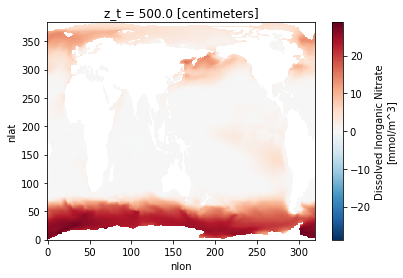

In [12]:
ds.NO3.isel(time=0,z_t=0).plot()

In [1]:
dt_wgt = ds.time_bound.diff('d2').squeeze()
dt_wgt /= dt_wgt.sum()
#dt_wgt

NameError: name 'ds' is not defined

In [15]:
ds = ds.weighted(dt_wgt).mean('time')

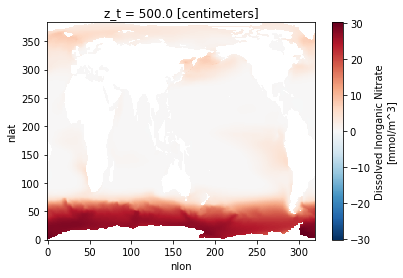

In [16]:
ds['NO3'].isel(z_t=0).plot()

### Compare long-term mean to World Ocean Atlas 2018

[WOA18](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/)

In [17]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds.z_t

In [18]:
NO3_diff = ds.NO3 - ds_woa.NO3
PO4_diff = ds.PO4 - ds_woa.PO4
SiO3_diff = ds.SiO3 - ds_woa.SiO3

### Surface comparison

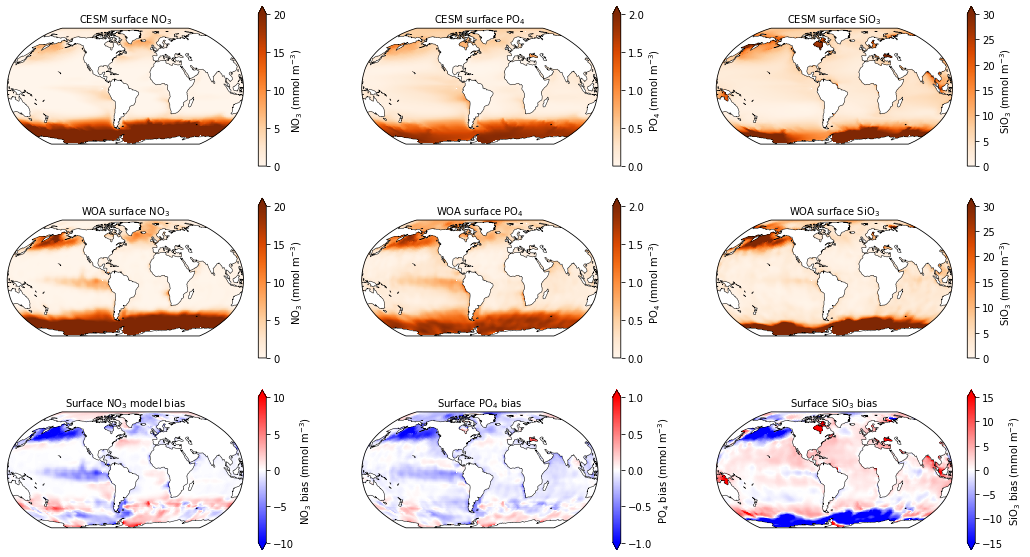

In [19]:
fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM surface NO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.NO3.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA surface NO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.NO3.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  NO3_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat, field, vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM surface PO$_4$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.PO4.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA surface PO$_4$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.PO4.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  PO4_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat,field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM surface SiO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.SiO3.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat, field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA surface SiO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.SiO3.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat,field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  SiO3_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat, field, 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)');

### Comparison at 100m

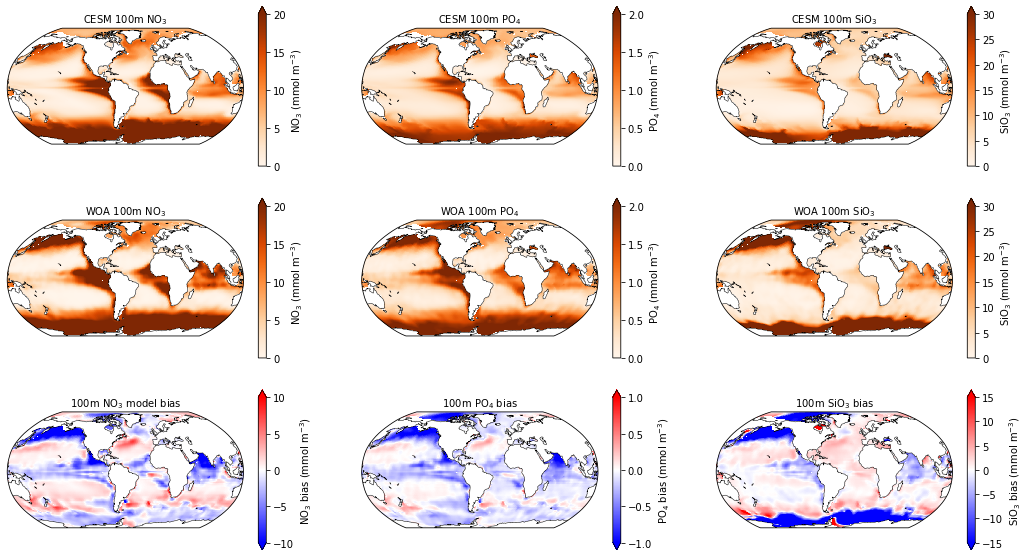

In [20]:
fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM 100m NO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.NO3.isel(z_t=10))
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA 100m NO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.NO3.isel(z_t=10))
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('100m NO$_3$ model bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  NO3_diff.isel(z_t=10))
pc3=ax.pcolormesh(lon, lat, field, vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM 100m PO$_4$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.PO4.isel(z_t=10))
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA 100m PO$_4$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.PO4.isel(z_t=10))
pc2=ax.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('100m PO$_4$ bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  PO4_diff.isel(z_t=10))
pc3=ax.pcolormesh(lon, lat,field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM 100m SiO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.SiO3.isel(z_t=10))
pc1=ax.pcolormesh(lon, lat, field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA 100m SiO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.SiO3.isel(z_t=10))
pc2=ax.pcolormesh(lon, lat,field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('100m SiO$_3$ bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  SiO3_diff.isel(z_t=10))
pc3=ax.pcolormesh(lon, lat, field, 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)');

### Global mean macronutrient profiles

In [61]:
ds_glb = util.global_mean(ds, ds_grid, ['NO3','PO4','SiO3']).compute()

In [62]:
ds_glb_woa = util.global_mean(ds_woa, ds_grid, ['NO3','PO4','SiO3']).compute()

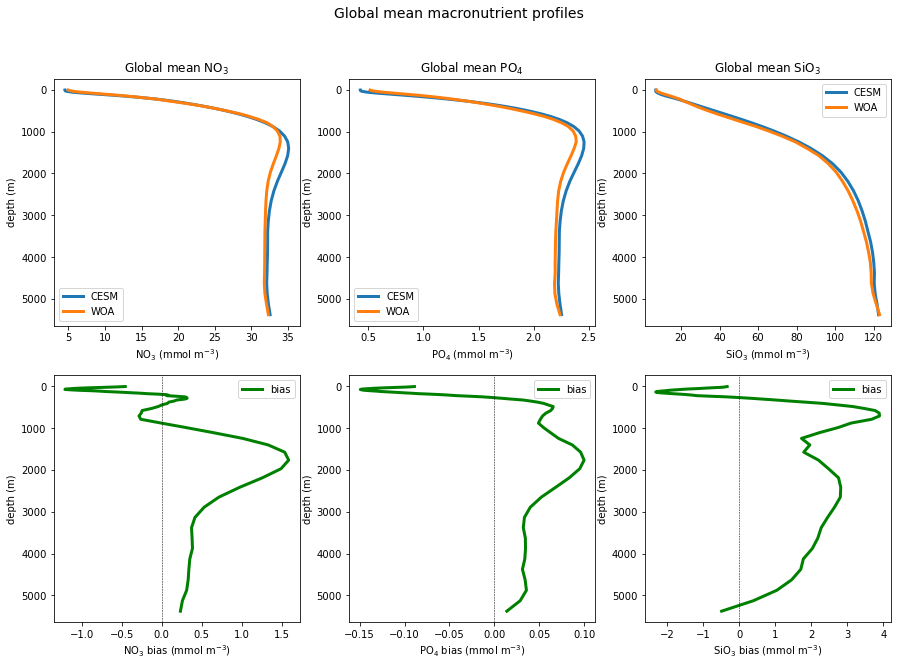

In [69]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
ax.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
ax.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
ax.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.gca().invert_yaxis()



#### **TO DO** 
• Add regional profiles